In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
from matplotlib import rcParams,font_manager
import os
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
rcParams['figure.figsize'] = (6,6) #figure size in inches
rcParams['font.family'] = "sans-serif" 
rcParams['font.weight'] = "roman" 
rcParams['font.style'] = "normal" # not 100% sure what this does but it was recommended
rcParams['font.size'] = 32 # not 100% sure what this does but it was recommended
rcParams['pdf.fonttype'] = 42
rcParams['axes.linewidth'] = 2 #thickness of the border
rcParams['xtick.major.width'] = rcParams['axes.linewidth'] # make sure line widths are consistent
rcParams['ytick.major.width'] = rcParams['axes.linewidth']
rcParams['axes.spines.right'] = False #hides right border
rcParams['axes.spines.top'] = False #hides top
rcParams['legend.frameon'] = False #hides box around the legend
rcParams['legend.fontsize'] = 18 #font size in pt
rcParams['axes.labelsize'] = 32 
rcParams['xtick.labelsize'] = 24
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize']
rcParams['lines.linewidth'] = 3
rcParams['xtick.major.size'] = 5
rcParams['lines.markersize'] = 16
rcParams['ytick.major.size'] = rcParams['xtick.major.size'] 

In [3]:
direc = 'C:/Users/svo/Google Drive/Bas Games/Analysis/'
fig_direc = 'C:/Users/svo/Google Drive/Bas Games/Figures/'

In [4]:
import matplotlib.patches as patches
import matplotlib.colors as colors

cm = colors.LinearSegmentedColormap.from_list('gray_gold_map', [colors.to_rgb('darkgray'), 
                                                                colors.to_rgb('gold')], N=100)
def show_board(bp,wp,response,color,save=False):    
    fig = plt.figure(figsize=[9,4])
    ax = fig.add_subplot(111,aspect='equal')
    ax.vlines(np.arange(-0.5,9.5,1),-0.5,3.5)
    ax.hlines(np.arange(-0.5,4.5,1),-0.5,8.5)
    
    black_pieces = np.nonzero(np.array(list(bp)).astype(int))[0]
    white_pieces = np.nonzero(np.array(list(wp)).astype(int))[0]
    
    for p in black_pieces:
        circ = patches.Circle((p%9,p//9),0.33,color="black",fill=True)
        circ = ax.add_patch(circ)
    for p in white_pieces:
        circ = patches.Circle((p%9,p//9),0.33,color="white",fill=True)
        circ = ax.add_patch(circ)
    for p in [response]:
        circ = patches.Circle((p%9,p//9),0.33,color=color,fill=False)
        circ = ax.add_patch(circ)
    plt.imshow(np.zeros(shape=[4,9]), cmap=cm, 
               interpolation='nearest',origin='bottom',vmin=0,vmax=0.2)
    ax.axis('off')
    fig.tight_layout()
    #if save:
    #    fig.savefig('C:/Users/svo/Documents/fmri/Boards/board_' + bp + '_' + wp + '.png')
    plt.show()

In [5]:
def plot_with_errorbars(fig,ax,x,A,colors=None):
    m = np.nanmean(A,axis=0)
    s = np.nanstd(A-m[None,:],axis=0)/np.sqrt(A.shape[0])
    plt.errorbar(x,m,yerr = s,color='black')
    if not colors is None:
        ax.scatter(x,m,color=colors)
    else:
        ax.plot(x,m,'.')

In [6]:
#time_colors = ['#9B1A30','#F85D5F','#FFAC9A']
#learn_colors = ['#4B8F7C', '#3C7864', '#2E614D','#1F4935','#10321D']
#peak_colors = ['#00B4D8','#0096C7','#0077B6','#023E8A','#03045E']

time_colors = ['#9F4AB0','#6E207D','#430F4D']
learn_colors = ['#7DE3AC', '#0EE676', '#129951','#17452D','#20382B']
peak_colors = ['#D7E8FA','#A3CDF7','#3C92E8','#0E5296','#0F3153']

In [7]:
import pandas as pd
boards_hvh = pd.read_csv(direc+'Opt/opt_hvh.txt',delim_whitespace=True,header=None)[[0,1]].values

In [8]:
move_stats_hvh = np.loadtxt(direc + 'Move statistics/move_stats_hvh.txt',dtype=int)
#columns are player id, color, cross-validation group, number of pieces, chosen move, and response time in ms
num_pieces_hvh = move_stats_hvh[:,3]

In [9]:
peak_direc = 'C:/Users/svo/Documents/FourinarowData/Data/peak/'

In [10]:
def load_params_file(filename):
    if os.path.exists(filename):
        return np.loadtxt(filename,delimiter=',')
    else:
        return np.full(shape=[10,],fill_value=np.nan)

def expand_params(params):
    return np.hstack([[10000],params[:2],params[3:4],[1,1],params[5:6],
                    np.tile(params[6:],4),[0],params[4]*np.tile(params[6:],4),
                    [0],np.tile(params[2:3],17)])

def shrink_params(p):
    return np.hstack([p[[1,2,41,3]],np.nanmean(p[24:28]/p[7:11]),p[6:11]])

def get_peak_user_id(i):
    df = pd.read_csv(peak_direc + 'splits/' + str(i+1) + '/data.csv',delim_whitespace=True,header=None)
    names = pd.unique(df[6])
    assert len(names)==1
    name = names[0]
    return name[:10] + '_block' + name[10:]
    #selected_peak_users = np.unique([player[:player.find('_')] for player in rating_dict.keys() if '_block' in player])


In [168]:
def get_peak_rt(i):
    df = pd.read_csv(peak_direc + 'splits/' + str(i+1) + '/data.csv',delim_whitespace=True,header=None)
    return df[df[4]<10][4].mean()
    #selected_peak_users = np.unique([player[:player.find('_')] for player in rating_dict.keys() if '_block' in player])


In [169]:
peak_rts = [get_peak_rt(i) for i in range(5000)]


In [11]:
import json
with open(direc + 'Ratings/ratings_all_expts_peak.txt') as f:
    rating_dict = json.load(f)

ratings_learn = np.array([[rating_dict['subj' + str(j).zfill(2) + 'sess' + str(i).zfill(2)] for i in range(5)] for j in range(30)])
ratings_time = np.array([[rating_dict['subj' + str(j).zfill(2) + 'cond' + str(i).zfill(2)] for i in range(3)] for j in range(30)])

In [12]:
peak_user_ids = [get_peak_user_id(i) for i in range(5000)]


In [130]:
peak_user_ids[0]

'AbAruGxhKA_block20'

In [13]:
np.savetxt(peak_direc + 'params_peak_final.txt',np.vstack([expand_params(np.loadtxt(peak_direc + 'splits/' + str(i+1) + '/params' + str(j) + '.csv',delimiter=',')) 
                                              for i in range(5000) for j in range(1,6)]),fmt='%.5f')

In [14]:
ratings_peak = np.reshape(np.array([rating_dict[u] for u in peak_user_ids]),[-1,5])

In [15]:
params_peak = np.array([[expand_params(load_params_file(peak_direc + 'splits/' + str(i+1) + '/params' + str(j+1) + '.csv')) 
                                       for j in range(5)]
                        for i in range(0,5000)])
params_peak = np.reshape(params_peak,[-1,5,5,58]) 

In [16]:
params_learn = np.reshape(np.loadtxt(direc + 'Params/params_learn_final.txt'),[30,5,5,58])
params_time = np.reshape(np.loadtxt(direc + 'Params/params_tai_final.txt'),[30,3,5,58])
feature_drop_rate_learn = params_learn[:,:,:,-1]
feature_drop_rate_time = params_time[:,:,:,-1]
feature_drop_rate_peak = params_peak[:,:,:,-1]

In [17]:
filename = direc + 'Learning/depth_learn.npy'
if os.path.exists(filename):
    depth_learn = np.load(filename,allow_pickle=True)
else: 
    depth_learn = np.reshape([[np.mean(np.loadtxt(direc + 'Learning/splits/'+str(i)+'/pv_depth_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,150)],[30,5,5])
    np.save(filename,depth_learn,allow_pickle=True)

In [18]:
filename = direc + 'Timed AI/depth_time.npy'
if os.path.exists(filename):
    depth_time = np.load(filename,allow_pickle=True)
else: 
    depth_time = np.reshape([[np.mean(np.loadtxt(direc + 'Timed AI/splits/'+str(i)+'/pv_depth_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,90)],[30,3,5])
    np.save(filename,depth_time,allow_pickle=True)

In [19]:
filename = direc + 'Peak/depth_peak.npy'
if os.path.exists(filename):
    depth_peak = np.load(filename,allow_pickle=True)
else: 
    depth_peak = np.reshape([[np.mean(np.loadtxt(peak_direc + 'depth/depth_peak_final_'+str(i)+'_' + str(j) + '.txt'))
                       for j in range(1,6)] for i in range(5000)],[-1,5,5])    
    np.save(filename,depth_peak,allow_pickle=True)

In [20]:
def get_heuristic_quality(params):
    f3inarow = (params[:,:,:,9]+params[:,:,:,28])/2
    heuristic_values = np.tanh(0.4*np.sum((-2*player_color+1)[None,None,None,:,None]*feature_counts[None,None,None,:]
                                                *params[:,:,:,None,6:41]/f3inarow[:,:,:,None,None],axis=4))
    return np.apply_along_axis(lambda x: np.corrcoef(x,optimal_board_values)[0,1],3,heuristic_values)


In [23]:
feature_counts = np.loadtxt(direc + 'Opt/optimal_feature_vals.txt')[:,-35:]
optimal_move_values = np.loadtxt(direc + 'Opt/opt_hvh.txt')[:,-36:]
mask = ~np.isnan(optimal_move_values)
optimal_move_values[mask] = np.vectorize(lambda x: -1 if x<-5000 else (1 if x>5000 else 0))(optimal_move_values[mask])
player_color = move_stats_hvh[:,1]
optimal_board_values = np.full_like(player_color,fill_value=np.nan,dtype=float)
optimal_board_values[player_color==0] = np.nanmax(optimal_move_values[player_color==0,:],axis=1)
optimal_board_values[player_color==1] = -np.nanmin(optimal_move_values[player_color==1,:],axis=1)


In [25]:
heuristic_quality_learn = get_heuristic_quality(params_learn)
heuristic_quality_time = get_heuristic_quality(params_time)
heuristic_quality_peak = np.vstack([get_heuristic_quality(params_peak[100*i:100*(i+1)]) for i in range(10)])

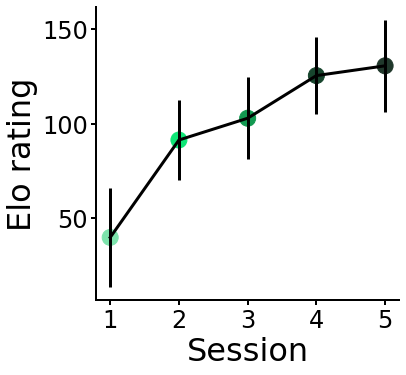

In [26]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),ratings_learn,colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Elo rating')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3a.pdf')
plt.show()

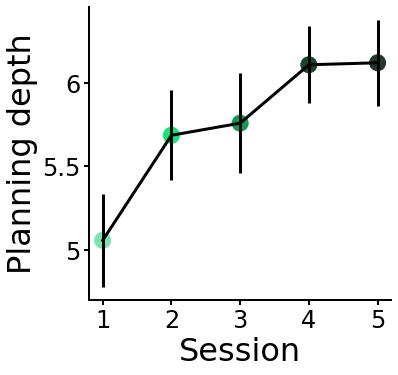

In [27]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.mean(depth_learn,axis=2),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Planning depth')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

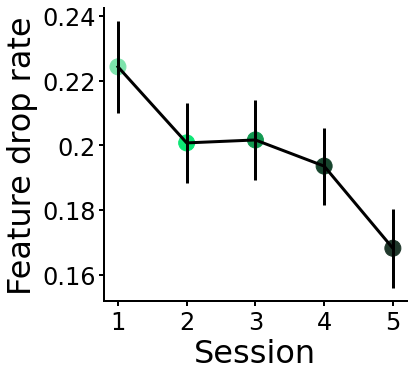

In [28]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.mean(feature_drop_rate_learn,axis=2),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Feature drop rate')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3c.pdf')
plt.show()

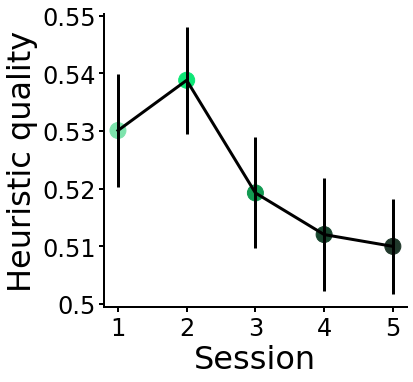

In [103]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.mean(heuristic_quality_learn,axis=2),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Heuristic quality')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3d.pdf')
plt.show()

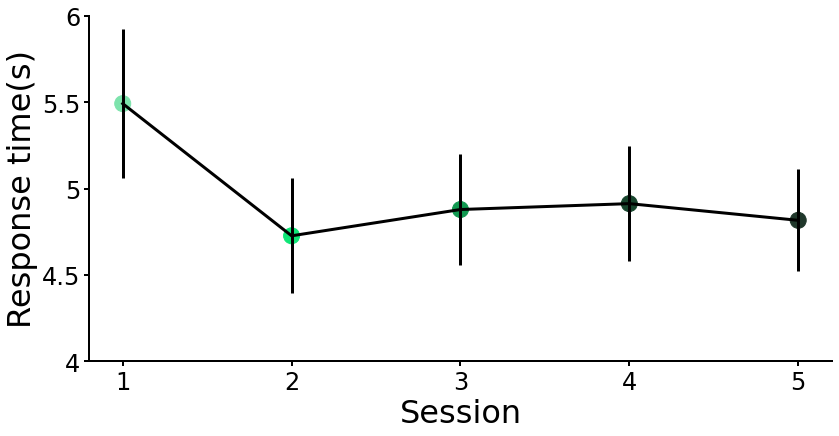

In [176]:
T = np.loadtxt(direc + 'Learning/time_learn.txt')
thinking_time = [np.mean(T[T[:,0]==i,1])/1000 for i in range(150)]

fig,ax=plt.subplots(figsize=(12,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),np.reshape(thinking_time,[30,5]),colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Response time(s)')
ax.set_xticks(range(1,6))
ax.set_yticks(np.arange(4,6.5,0.5))
fig.subplots_adjust(bottom=0.15,right=0.98,left=0.12,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_16.pdf')
plt.show()

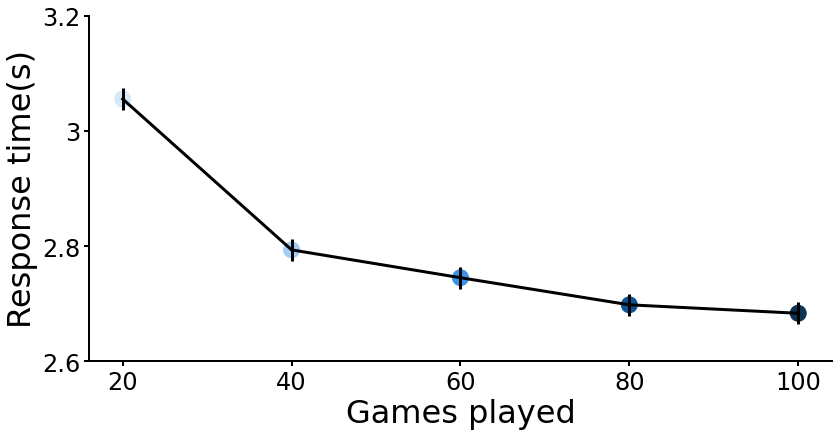

In [250]:
fig,ax=plt.subplots(figsize=(12,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.reshape(peak_rts,[1000,5]),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_xticks(np.arange(20,120,20))
ax.set_ylabel('Response time(s)')
ax.set_yticks(np.arange(2.6,3.4,0.2))
fig.subplots_adjust(bottom=0.15,right=0.98,left=0.12,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_17.pdf')
plt.show()

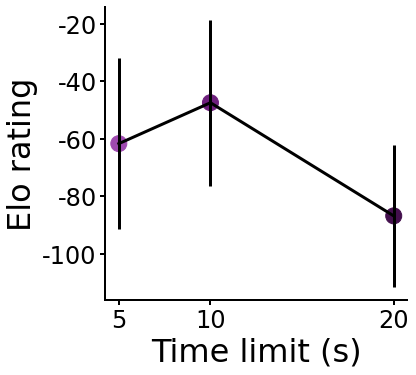

In [30]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],ratings_time,colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Elo rating')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3e.pdf')
plt.show()

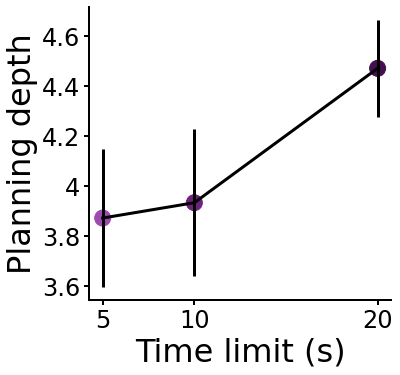

In [31]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],np.mean(depth_time,axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Planning depth')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3f.pdf')
plt.show()

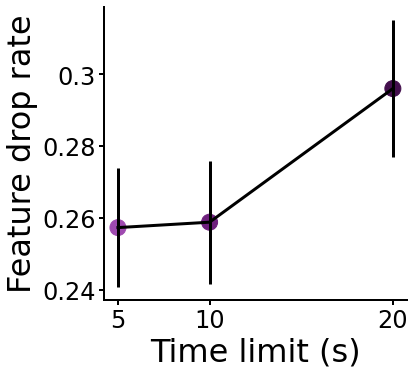

In [32]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],np.mean(feature_drop_rate_time,axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Feature drop rate')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3g.pdf')
plt.show()

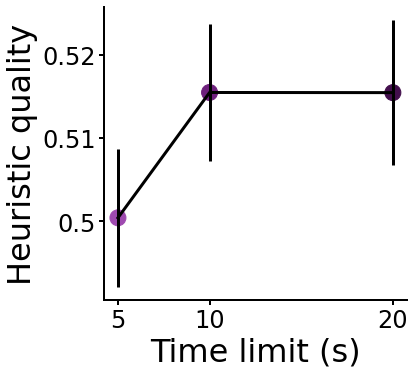

In [33]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,[5,10,20],np.mean(heuristic_quality_time,axis=2),colors=time_colors)
ax.set_xlabel('Time limit (s)')
ax.set_ylabel('Heuristic quality')
ax.set_xticks([5,10,20])
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_3h.pdf')
plt.show()

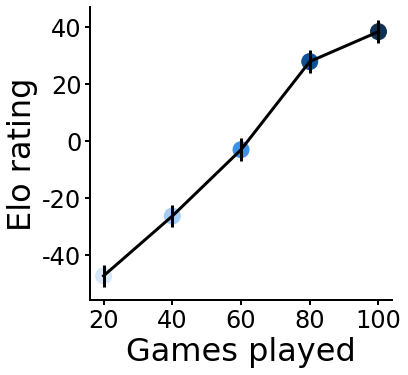

In [34]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),ratings_peak,colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Elo rating')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4a.pdf')
plt.show()

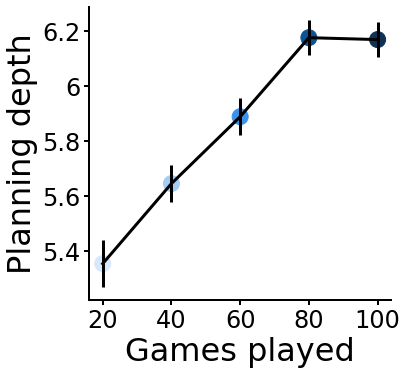

In [35]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.mean(depth_peak,axis=2),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Planning depth')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4b.pdf')
plt.show()

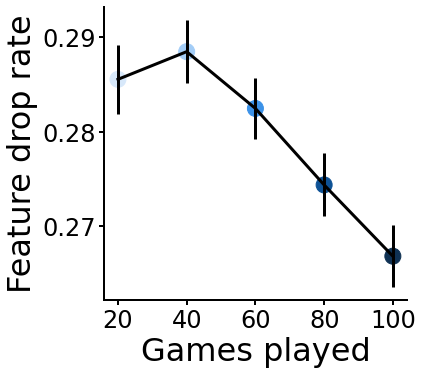

In [36]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.mean(feature_drop_rate_peak,axis=2),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Feature drop rate')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4c.pdf')
plt.show()

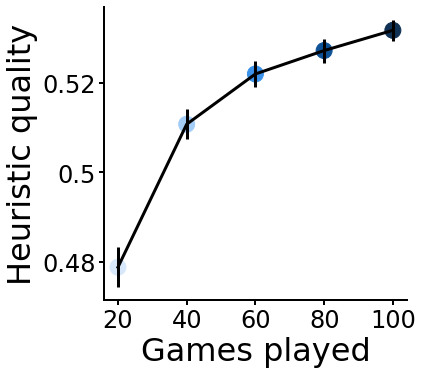

In [37]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,np.arange(20,120,20),np.mean(heuristic_quality_peak,axis=2),colors=peak_colors)
ax.set_xlabel('Games played')
ax.set_ylabel('Heuristic quality')
ax.set_xticks(np.arange(20,120,20))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'figure_4d.pdf')
plt.show()

In [38]:
print('depth')
for x,y in zip([range(5),[5,10,20],range(5)],[depth_learn,depth_time,depth_peak]):
    print(sts.pearsonr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))
    print(sts.spearmanr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))

print('feature drop rate')
for x,y in zip([range(5),[5,10,20],range(5)],[feature_drop_rate_learn,feature_drop_rate_time,feature_drop_rate_peak]):
    print(sts.pearsonr(np.tile(x,[y.shape[0],1]).flatten(),(np.mean(y,axis=2)-np.mean(y,axis=(1,2))[:,None]).flatten()))
    print(sts.spearmanr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))

print('heuristic quality')
for x,y in zip([range(5),[5,10,20],range(5)],[heuristic_quality_learn,heuristic_quality_time,heuristic_quality_peak]):
    print(sts.pearsonr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))
    print(sts.spearmanr(np.tile(x,[y.shape[0],1]).flatten(),np.mean(y,axis=2).flatten()))


depth
(0.23706751200183335, 0.0034897655202440238)
SpearmanrResult(correlation=0.21022532476198413, pvalue=0.00981991648760663)
(0.18178872209312902, 0.08637975483861456)
SpearmanrResult(correlation=0.22943102963134362, pvalue=0.02961110147144177)
(0.13677189344505533, 2.6153561805791774e-22)
SpearmanrResult(correlation=0.18702961732265772, pvalue=1.3627225161070281e-40)
feature drop rate
(-0.36427102484031776, 4.594118044920875e-06)
SpearmanrResult(correlation=-0.2733691302316634, pvalue=0.0007123648447403557)
(0.33137621643371185, 0.0014206612846463804)
SpearmanrResult(correlation=0.14876349866507213, pvalue=0.16170306067234747)
(-0.08716630939973675, 6.666738334470785e-10)
SpearmanrResult(correlation=-0.09633662093885091, pvalue=8.718969992066146e-12)
heuristic quality
(-0.18067166740348387, 0.026932374230636217)
SpearmanrResult(correlation=-0.18159287504038812, pvalue=0.026150564364931496)
(0.11473825278817673, 0.28154814576355564)
SpearmanrResult(correlation=0.1403824564867582, pv

In [39]:
#plt.plot(heuristic_values[0,0,0,player_color==0],optimal_board_values[player_color==0],'.',alpha=0.5)
#plt.plot(heuristic_values[0,0,0,player_color==1],optimal_board_values[player_color==1],'.',alpha=0.5)
#plt.show()

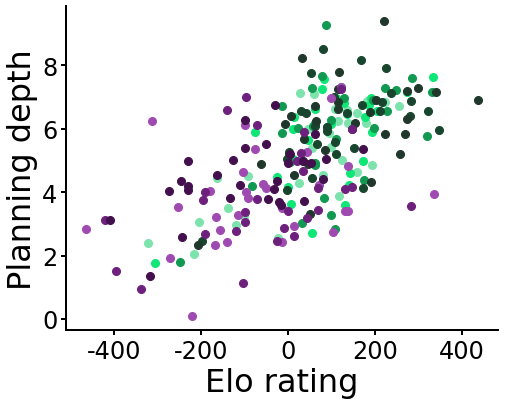

(0.621635264632611, 4.705742945381398e-27)

In [55]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(learn_colors):
    ax.plot(ratings_learn[:,i],np.mean(depth_learn,axis=2)[:,i],'.',color=c)
for i,c in enumerate(time_colors):
    ax.plot(ratings_time[:,i],np.mean(depth_time,axis=2)[:,i],'.',color=c)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Planning depth')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.2,top=0.95)
fig.savefig(fig_direc + 'supp_figure_14A.pdf')
plt.show()
sts.pearsonr(np.hstack([ratings_learn,ratings_time]).flatten(),
             np.hstack([np.mean(depth_learn,axis=2),np.mean(depth_time,axis=2)]).flatten())

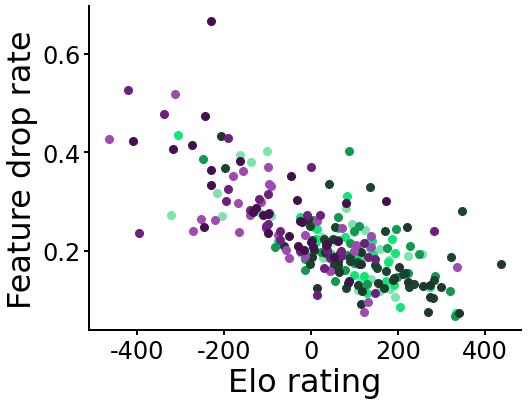

(-0.7346679332015988, 5.537315616945345e-42)

In [56]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(learn_colors):
    ax.plot(ratings_learn[:,i].flatten(),np.mean(feature_drop_rate_learn,axis=2)[:,i],'.',color=c,alpha=1)
for i,c in enumerate(time_colors):
    ax.plot(ratings_time[:,i].flatten(),np.mean(feature_drop_rate_time,axis=2)[:,i],'.',color=c,alpha=1)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Feature drop rate')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.2,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_14B.pdf')
plt.show()
sts.pearsonr(np.hstack([ratings_learn,ratings_time]).flatten(),
             np.hstack([np.mean(feature_drop_rate_learn,axis=2),np.mean(feature_drop_rate_time,axis=2)]).flatten())

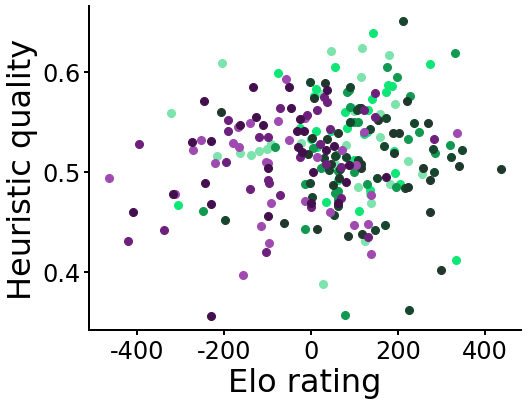

(0.1103670712690579, 0.08799160134920876)

In [59]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(learn_colors):
    ax.plot(ratings_learn[:,i].flatten(),np.mean(heuristic_quality_learn,axis=2)[:,i],'.',color=c)
for i,c in enumerate(time_colors):
    ax.plot(ratings_time[:,i].flatten(),np.mean(heuristic_quality_time,axis=2)[:,i],'.',color=c)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Heuristic quality')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.2,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_14C.pdf')
plt.show()
sts.pearsonr(np.hstack([ratings_learn,ratings_time]).flatten(),
             np.hstack([np.mean(heuristic_quality_learn,axis=2),np.mean(heuristic_quality_time,axis=2)]).flatten())

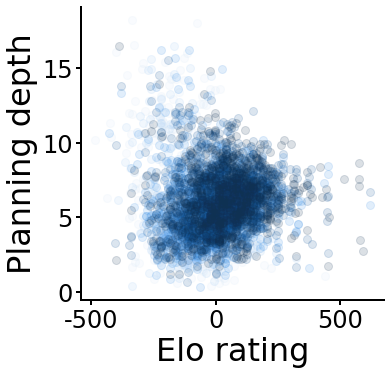

(0.024950902397863576, 0.07771030983516741)

In [60]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(peak_colors):
    ax.plot(ratings_peak[:,i].flatten(),np.mean(depth_peak,axis=2)[:,i],'.',color=c,alpha=0.15)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Planning depth')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_1b.pdf')
plt.show()
sts.pearsonr(ratings_peak.flatten(),np.mean(depth_peak,axis=2).flatten())

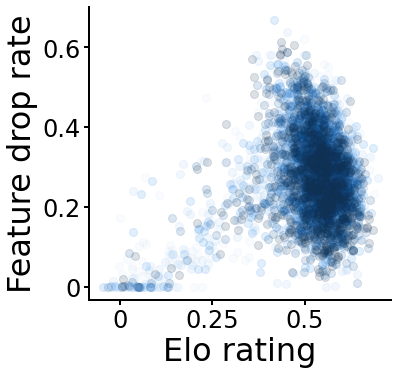

(-0.20684146204263734, 1.9033338573291157e-49)

In [61]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(peak_colors):
    ax.plot(np.mean(heuristic_quality_peak,axis=2)[:,i],np.mean(feature_drop_rate_peak,axis=2)[:,i],'.',color=c,alpha=0.15)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Feature drop rate')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_1b.pdf')
plt.show()
sts.pearsonr(ratings_peak.flatten(),np.mean(feature_drop_rate_peak,axis=2).flatten())

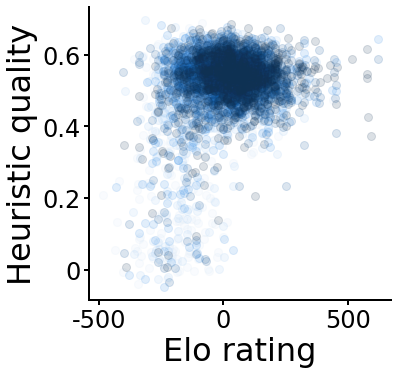

(0.2663468238559597, 5.842083265570738e-82)

In [62]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i,c in enumerate(peak_colors):
    ax.plot(ratings_peak[:,i].flatten(),np.mean(heuristic_quality_peak,axis=2)[:,i],'.',color=c,alpha=0.15)

ax.set_xlabel('Elo rating')
ax.set_ylabel('Heuristic quality')
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_1c.pdf')
plt.show()
sts.pearsonr(ratings_peak.flatten(),np.mean(heuristic_quality_peak,axis=2).flatten())

In [181]:
d1 = np.mean(np.reshape([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_hvh_final_' + str(i) + '_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,40)],[40,5]),axis=1)
d2 = np.mean(np.reshape([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_hvh_final2_' + str(i) + '_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,40)],[40,5]),axis=1)

In [182]:
f1 = np.mean(np.reshape(np.loadtxt(direc + 'Params/params_hvh_final.txt')[:,-1],[40,5]),axis=1)
f2 = np.mean(np.reshape(np.loadtxt(direc + 'Params/params_hvh_final2.txt')[:,-1],[40,5]),axis=1)

In [183]:
q1 = np.mean(get_heuristic_quality(np.reshape(np.loadtxt(direc + 'Params/params_hvh_final.txt'),[40,1,5,58])),axis=(1,2))
q2 = np.mean(get_heuristic_quality(np.reshape(np.loadtxt(direc + 'Params/params_hvh_final2.txt'),[40,1,5,58])),axis=(1,2))

In [189]:
sts.pearsonr(d1,d2),sts.pearsonr(f1,f2),sts.pearsonr(q1,q2)

((0.858547561782512, 1.4045305806288516e-12),
 (0.7374283164235721, 5.711066069502427e-08),
 (0.7659444776504395, 8.45790255505166e-09))

In [191]:
def plot_param_bars(rho,sem,names,xlabel,c,filename):
    fig,ax = plt.subplots(figsize=(8,6))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.set_xlim([0,1])
    ax.set_xlabel(xlabel,usetex=False)
    ax.barh(range(len(rho),0,-1), rho, xerr=sem, align='center',
        color=c, ecolor='black')
    plt.xticks(np.arange(0,1.2,0.5))
    plt.yticks(range(len(rho),0,-1),names, fontsize =18)
    fig.subplots_adjust(bottom=0.2,right=0.95,left=0.3)
    fig.savefig(fig_direc + filename)
    plt.show()

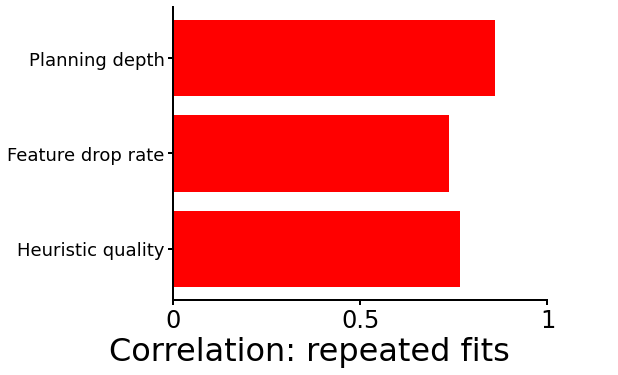

In [192]:
plot_param_bars(rho = [sts.pearsonr(d1,d2)[0],sts.pearsonr(f1,f2)[0],sts.pearsonr(q1,q2)[0]],sem=[0,0,0],
                names = ['Planning depth','Feature drop rate','Heuristic quality'],
                xlabel = 'Correlation: repeated fits          ',
                c='red',filename='supp_figure_5A.pdf')

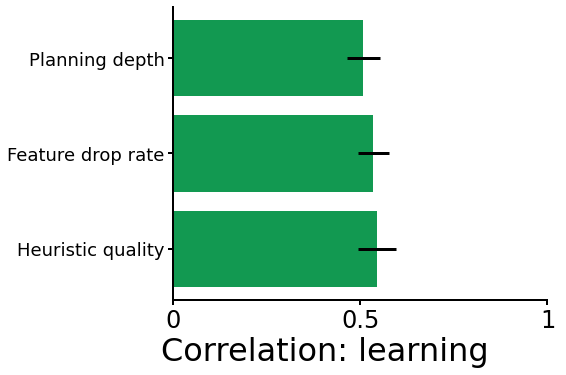

[0.5080186234580781, 0.5350385697672032, 0.5436233682130018] [0.04365641693664472, 0.04091539430631911, 0.050626215230089595] [Ttest_1sampResult(statistic=11.039586319525668, pvalue=1.5618822060569164e-06), Ttest_1sampResult(statistic=12.405652287031424, pvalue=5.798029052897701e-07), Ttest_1sampResult(statistic=10.18694380983705, pvalue=3.0663601478948094e-06)]


In [193]:
def plot_correlation_across_conditions(stats,names,xlabel,color,fig_name):
    rho = [np.mean(np.corrcoef(np.mean(x,axis=2).T)[np.triu_indices(x.shape[1],1)]) for x in stats]
    sem = [np.std(np.corrcoef(np.mean(x,axis=2).T)[np.triu_indices(x.shape[1],1)])/np.sqrt(10) for x in stats]
    plot_param_bars(rho,sem,names,xlabel,color,fig_name)
    print(rho,sem,[sts.ttest_1samp(np.corrcoef(np.mean(x,axis=2).T)[np.triu_indices(x.shape[1],1)],popmean=0) for x in stats])

plot_correlation_across_conditions([depth_learn,feature_drop_rate_learn,heuristic_quality_learn],
                               ['Planning depth','Feature drop rate','Heuristic quality'],
                               'Correlation: learning       ',learn_colors[2],'supp_figure_5B.pdf')

In [70]:
#for name,x in zip(['depth','feature drop rate','heuristic quality'],
#                  [depth_time,feature_drop_rate_time,heuristic_quality_time]):
#    print(name)
#    print('correlation across groups')
#    print(np.corrcoef(np.reshape(x,[90,5]).T))
#    print('correlation across sessions')
#    plt.imshow(np.corrcoef(np.mean(x,axis=2).T),vmin=-1,vmax=1,cmap='bwr')
#    plt.show()
#    print(np.corrcoef(np.mean(x,axis=2).T))

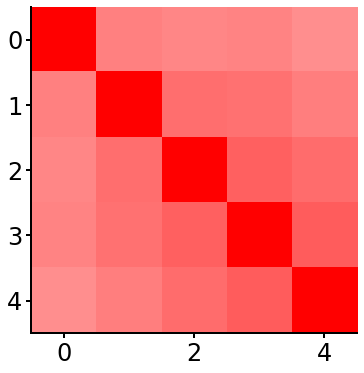

depth
correlation across groups
[[1.         0.26140224 0.21783031 0.23193443 0.2221281 ]
 [0.26140224 1.         0.26383053 0.24165868 0.24846855]
 [0.21783031 0.26383053 1.         0.21812955 0.23198767]
 [0.23193443 0.24165868 0.21812955 1.         0.26052157]
 [0.2221281  0.24846855 0.23198767 0.26052157 1.        ]]
correlation across games played


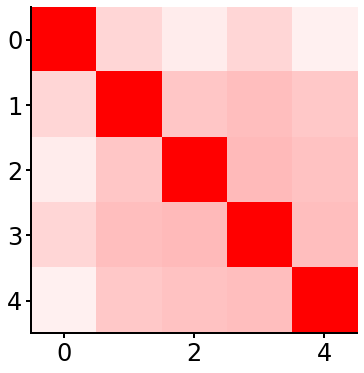

feature drop rate
correlation across groups
[[1.         0.31303213 0.31526355 0.31057657 0.32599297]
 [0.31303213 1.         0.31459787 0.3100178  0.3409036 ]
 [0.31526355 0.31459787 1.         0.31825414 0.29668038]
 [0.31057657 0.3100178  0.31825414 1.         0.31947802]
 [0.32599297 0.3409036  0.29668038 0.31947802 1.        ]]
correlation across games played


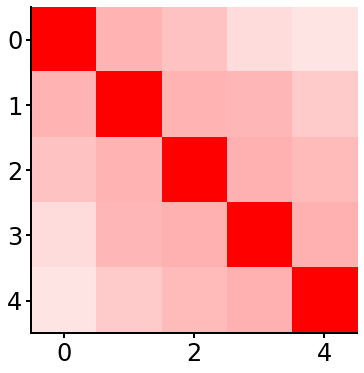

heuristic quality
correlation across groups
[[1.         0.56310769 0.53719631 0.54428365 0.55066345]
 [0.56310769 1.         0.54487827 0.55261717 0.57263666]
 [0.53719631 0.54487827 1.         0.54583427 0.54545555]
 [0.54428365 0.55261717 0.54583427 1.         0.58238419]
 [0.55066345 0.57263666 0.54545555 0.58238419 1.        ]]
correlation across games played


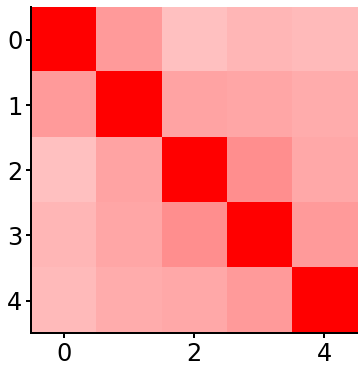

In [71]:
plt.imshow(np.corrcoef(ratings_peak.T),vmin=-1,vmax=1,cmap='bwr')
plt.show()

for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_peak,feature_drop_rate_peak,heuristic_quality_peak]):
    print(name)
    print('correlation across groups')
    print(np.corrcoef(np.reshape(x,[-1,5]).T))
    print('correlation across games played')
    plt.imshow(np.corrcoef(np.mean(x,axis=2).T),vmin=-1,vmax=1,cmap='bwr')
    plt.show()

In [72]:
import pandas as pd
import statsmodels.formula.api as sm

def get_slopes(elo,tree,feat,qual):
    p = sm.ols(formula="y ~ tree + feat + qual",
               data=pd.DataFrame({'y' : elo,'tree': tree,'feat' : feat,'qual' : qual})
              ).fit().params
    return [p[x] for x in ['tree','feat','qual','Intercept']]

In [73]:
slopes = [get_slopes(ratings_learn[:,i],np.mean(depth_learn,axis=2)[:,i],
                     np.mean(feature_drop_rate_learn,axis=2)[:,i],np.mean(heuristic_quality_learn,axis=2)[:,i])
                 for i in range(5)]
ratings_learn_pred = np.mean(np.sum([s*A for s,A in zip(np.mean(slopes,axis=0),
                                                [depth_learn,feature_drop_rate_learn,heuristic_quality_learn])],axis=0),axis=2)
ratings_learn_pred += np.mean(slopes,axis=0)[-1]

In [74]:
list(zip(np.mean(slopes,axis=0),np.std(slopes,axis=0)/np.sqrt(5)))

[(34.33855831906621, 4.87182227139502),
 (-825.6462440926438, 109.20294304562962),
 (330.51753402348737, 159.66354821552207),
 (-107.26254919787125, 97.5388764304732)]

In [75]:
np.array(slopes)

array([[   54.82027097,  -681.05679514,   250.00330538,  -217.27475182],
       [   22.80390763, -1128.29476579,   154.18877563,   105.06191619],
       [   30.98794011,  -759.32979064,  1018.60230375,  -451.37122236],
       [   34.17954585,  -482.26560122,   243.91496649,  -114.85153416],
       [   28.90112703, -1077.28426768,   -14.12168114,   142.12284616]])

In [76]:
print(np.mean(ratings_learn[:,-1]-ratings_learn[:,0]),np.std(ratings_learn[:,-1]-ratings_learn[:,0])/np.sqrt(30))

for s,x in zip(np.mean(slopes,axis=0),[depth_learn,feature_drop_rate_learn,heuristic_quality_learn]):
    print(s,s*np.mean(x[:,-1]-x[:,0]),np.abs(s)*np.std(np.mean(x[:,-1,:]-x[:,0,:],axis=1))/np.sqrt(x.shape[0]))

90.9 26.325034557326692
34.33855831906621 36.49770990667311 11.440496383234938
-825.6462440926438 46.29669333144427 12.272295149298326
330.51753402348737 -6.648150524956029 3.5569369022281654


In [77]:
slopes = [get_slopes(ratings_peak[:,i],np.mean(depth_peak,axis=2)[:,i],
                     np.mean(feature_drop_rate_peak,axis=2)[:,i],np.mean(heuristic_quality_peak,axis=2)[:,i])
                 for i in range(5)]
ratings_peak_pred = np.mean(np.sum([s*A for s,A in zip(np.mean(slopes,axis=0),
                                                [depth_peak,feature_drop_rate_peak,heuristic_quality_peak])],axis=0),axis=2)
ratings_peak_pred += np.mean(slopes,axis=0)[-1]

In [78]:
print(np.mean(ratings_peak[:,-1]-ratings_peak[:,0]),np.std(ratings_peak[:,-1]-ratings_peak[:,0])/np.sqrt(1000))

for s,x in zip(np.mean(slopes,axis=0),[depth_peak,feature_drop_rate_peak,heuristic_quality_peak]):
    print(s,s*np.mean(x[:,-1]-x[:,0]),np.abs(s)*np.std(np.mean(x[:,-1,:]-x[:,0,:],axis=1))/np.sqrt(x.shape[0]))

85.729 4.261878172707427
1.1389009875513747 0.929061393467561 0.1165297218747842
-327.8386765977715 6.1393619531768024 1.5209975261757909
334.68069656512296 17.71039935825264 1.4730095857569732


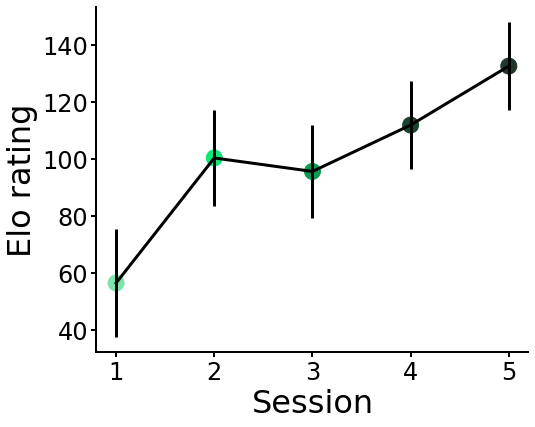

In [90]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

plot_with_errorbars(fig,ax,range(1,6),ratings_learn_pred,colors=learn_colors)
#plot_with_errorbars(fig,ax,range(1,6),ratings_learn,colors=learn_colors)
ax.set_xlabel('Session')
ax.set_ylabel('Elo rating')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.15,right=0.95,left=0.2,top=0.95)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
fig.savefig(fig_direc + 'supp_figure_14B.pdf')
plt.show()

In [85]:
1-np.sum((ratings_learn_pred-ratings_learn)**2)/np.sum((ratings_learn-np.mean(ratings_learn))**2)

0.5671226685881331

In [86]:
sts.pearsonr(ratings_learn_pred.flatten(),ratings_learn.flatten())

(0.7535752452391471, 9.371721008904908e-29)

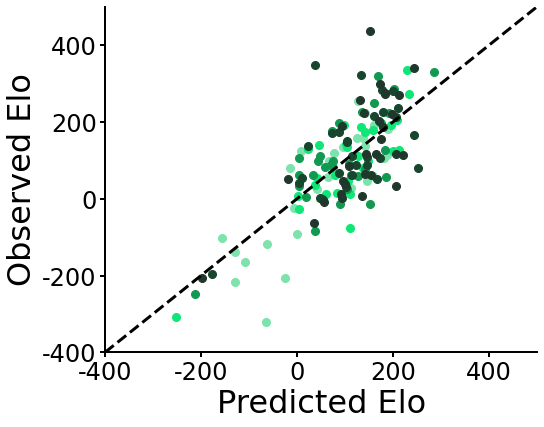

In [91]:
fig,ax=plt.subplots(figsize=(8,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for i in range(5):
    ax.plot(ratings_learn_pred[:,i],ratings_learn[:,i],'.',color=learn_colors[i])
ax.plot([-400,500],[-400,500],color='black',linestyle='dashed')
ax.set_xlabel('Predicted Elo')
ax.set_ylabel('Observed Elo')
ax.set_xlim([-400,500])
ax.set_ylim([-400,500])
fig.subplots_adjust(bottom=0.15,right=0.95,left=0.2,top=0.95)
fig.savefig(fig_direc + 'supp_figure_14A.pdf')
plt.show()

In [92]:
def test_significance(A,x):
    df = pd.DataFrame({'y' : A.flatten(),'subj': np.repeat(range(A.shape[0]),A.shape[1]),'cond' : np.tile(x,A.shape[0])})
    res = sm.ols(formula="y ~ cond + C(subj)",data=df).fit()
    return res.params['cond'],np.mean((res.conf_int(alpha=0.05).loc['cond'].values-res.params['cond'])*[-1,1]),res.pvalues['cond']


In [93]:
for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_learn,feature_drop_rate_learn,heuristic_quality_learn]):
    print(name,test_significance(np.mean(x,axis=2),range(5)))


depth (0.25476956341967216, 0.11991745369176254, 5.047065689915806e-05)
feature drop rate (-0.011931538740666678, 0.005536964956214858, 4.0008722131850343e-05)
heuristic quality (-0.006701891926174163, 0.004009065819102823, 0.0012346860007524843)


In [94]:
for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_time,feature_drop_rate_time,heuristic_quality_time]):
    print(name,test_significance(np.mean(x,axis=2),[5,10,20]))


depth (0.04197951477562849, 0.03521652882245481, 0.020297291685353328)
feature drop rate (0.002745076666666612, 0.0020360785581206822, 0.009087415159395587)
heuristic quality (0.0008581117204592088, 0.0011287529058825354, 0.1335472134302246)


In [95]:
for name,x in zip(['depth','feature drop rate','heuristic quality'],
                  [depth_peak,feature_drop_rate_peak,heuristic_quality_peak]):
    print(name,test_significance(np.mean(x,axis=2),range(5)))


depth (0.21627211529657894, 0.039357340998154716, 1.0649113862940955e-26)
feature drop rate (-0.005156237961342281, 0.0018269723352591445, 3.344744688113817e-08)
heuristic quality (0.012229740453663429, 0.0016645576276174846, 6.706957454852402e-46)


In [96]:
test_significance(ratings_peak,range(5))

(22.570700000000055, 1.7085810348156052, 7.343332179124965e-137)

In [97]:
test_significance(ratings_learn,range(5))

(21.593333333333145, 9.16952177478817, 8.215248031531198e-06)

In [98]:
models=['final','final_nonoise','final_nodelta','final_noprune','final_notree','final_noact','final_no3',
        'final_no2conn','final_nocenter','final_no4','final_no2unc',
        'final_optweights','final_mcts_myopic','final_drop_tile','final_fixed_iters',
        'final_fixed_depth','final_fixed_branch','final_weight_hvd','final_drop_hvd',
        'final_triangle','final_drop_type','final_opp']
models=['final','final_nonoise','final_nodelta','final_noprune','final_notree','final_noact','final_no3',
        'final_no2conn','final_nocenter','final_no4','final_no2unc',
        'final_optweights','final_weight_hvd','final_drop_hvd',
        'final_triangle','final_drop_type','final_opp','final_drop_tile',
        'final_fixed_branch','final_fixed_iters','final_fixed_depth']

model_names = ['Main','No value noise','No feature drop','No pruning','No tree','No active scaling',
               'No 3-in-a-row','No connected 2-in-a-row','No center','No 4-in-a-row',
               'No unconnected 2-in-a-row','Optimal weights',
               'Tile dropping','Fixed iterations','Fixed depth','Fixed branching',
               'Orientation-dependent weights','Orientation-dependent dropping','Triangle',
               'Type-dependent dropping','Opponent scaling']


In [99]:
with open(direc + 'Planning depth/depth/depth_learn_final_fixed_depth_pickle.txt','wb') as f:
    pickle.dump(np.reshape(np.loadtxt(direc + 'Params/params_learn_final_fixed_depth.txt'),[30,5,5,58])[:,:,:,1],file=f)



In [100]:
def get_depth(m):
    print(m)
    filename = direc + 'Planning depth/depth/depth_learn_' + m + '_pickle.txt'
    if os.path.exists(filename):
        with open(filename,'rb') as f:
            return pickle.load(f)
    return np.reshape([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_learn_' + m + '_' + str(i) + '_' + str(j) + '.txt'))
                           for j in range(1,6)] for i in range(0,150)],[30,5,5])
    
depth_learn_models =  [get_depth(m) for m in models]

final
final_nonoise
final_nodelta
final_noprune
final_notree
final_noact
final_no3
final_no2conn
final_nocenter
final_no4
final_no2unc
final_optweights
final_weight_hvd
final_drop_hvd
final_triangle
final_drop_type
final_opp
final_drop_tile
final_fixed_branch
final_fixed_iters
final_fixed_depth


In [101]:
import pickle
for d,m in zip(depth_learn_models,models):
    with open(direc + 'Planning depth/depth/depth_learn_' + m + '_pickle.txt','wb') as f:
        pickle.dump(d,file=f)

In [201]:
heuristic_quality_learn_models = [get_heuristic_quality(np.reshape(np.loadtxt(direc + 'Params/params_learn_' + m + '.txt'),
                                                                   [30,5,5,58])) for m in models]

In [202]:
feature_drop_learn_models = [np.reshape(np.loadtxt(direc + 'Params/params_learn_' + m + '.txt'),[30,5,5,58])[:,:,:,-15]
                       for m in models]

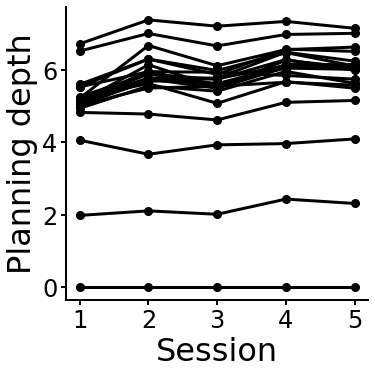

In [203]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for d in depth_learn_models:
    ax.plot(range(1,6),np.mean(d,axis=(0,2)),'.-',color='black')
ax.set_xlabel('Session')
ax.set_ylabel('Planning depth')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

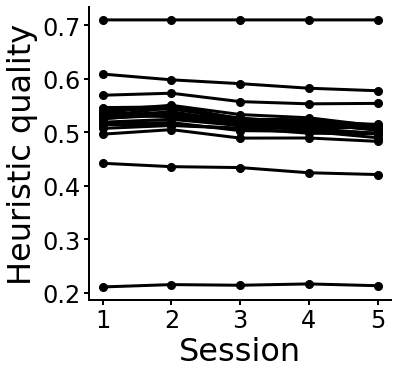

In [204]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for q in heuristic_quality_learn_models:
    ax.plot(range(1,6),np.mean(q,axis=(0,2)),'.-',color='black')
ax.set_xlabel('Session')
ax.set_ylabel('Heuristic quality')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

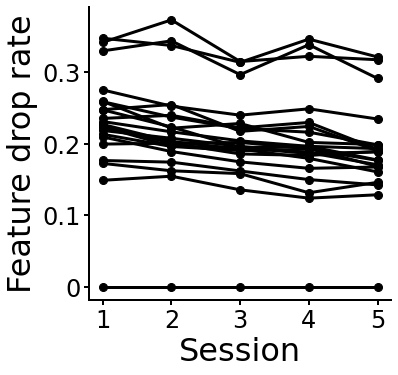

In [205]:
fig,ax=plt.subplots(figsize=(6,6))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))

for f in feature_drop_learn_models:
    ax.plot(range(1,6),np.mean(f,axis=(0,2)),'.-',color='black')
ax.set_xlabel('Session')
ax.set_ylabel('Feature drop rate')
ax.set_xticks(range(1,6))
fig.subplots_adjust(bottom=0.2,right=0.95,left=0.25)
#plt.text(0,0.9,'A',ha='right',va='top',transform=fig.transFigure)
#fig.savefig(fig_direc + 'figure_3b.pdf')
plt.show()

In [206]:
for d,q,f,m in zip(depth_learn_models,heuristic_quality_learn_models,feature_drop_learn_models,models):
    print(m)
    slopes = [get_slopes(ratings_learn[:,i],np.mean(d,axis=2)[:,i],np.mean(f,axis=2)[:,i],np.mean(q,axis=2)[:,i])
                     for i in range(5)]
    ratings_learn_pred = np.mean(np.sum([s*A for s,A in zip(np.mean(slopes,axis=0),[d,f,q])],axis=0),axis=2)
    ratings_learn_pred += np.mean(slopes,axis=0)[-1]
    for s,x in zip(np.mean(slopes,axis=0),[d,f,q]):
        print(s*np.mean(x[:,-1]-x[:,0]),np.abs(s)*np.std(np.mean(x[:,-1,:]-x[:,0,:],axis=1))/np.sqrt(x.shape[0]))

final
36.49770990667313 11.440496383234944
46.29669333144426 12.272295149298325
-6.6481505249560335 3.5569369022281676
final_nonoise
16.591620511930827 9.574493219695228
16.546352548668022 14.148730062743395
0.9251515673154491 6.18485802052369
final_nodelta
10.229521697944563 14.382921540785683
0.0 0.0
-3.718595273228667 1.6559432280648312
final_noprune
17.664463014924976 13.935879266818473
23.880330083239645 8.25177020985621
-8.39062722146547 4.899145255989044
final_notree
0.0 0.0
22.786444453565657 14.960784456333776
-0.4442503193309003 0.13816856605773445
final_noact
39.98822833338194 15.750611326496385
46.57582675821191 14.933104506991409
-19.43564954592723 7.852939479848964
final_no3
35.62935092941772 17.674745308863475
4.710261840424273 4.710120988226555
-0.8409668305591094 1.9484023625823956
final_no2conn
45.43143636924869 18.940173605663716
25.37209020617119 8.878655578004452
7.475361000592662 3.321000018537688
final_nocenter
39.593753814350244 10.873390071493807
42.76655210302

In [207]:
def report_stats(s):
    rho,p = s
    if np.isnan(p):
        return '\\multicolumn{2}{c |}{N/A}'
    elif p>0.01:
        return '$' + '{0:.2f}'.format(rho) + '$ & $' + '{:.2f}'.format(p) + '$'
    else:
        return '$' + '{0:.2f}'.format(rho) + '$ & $' + '{:.1e}'.format(p).split('e')[0] + '\cdot 10^{' + str(int('{0:.1e}'.format(p).split('e')[1])) + '}$'

for d,q,f,m in zip(depth_learn_models,heuristic_quality_learn_models,feature_drop_learn_models,model_names):
    print(m,'&',report_stats(sts.pearsonr(np.mean(d,axis=2).flatten(),ratings_learn.flatten())),'&',
          report_stats(sts.pearsonr(np.mean(f,axis=2).flatten(),ratings_learn.flatten())),'&',
          report_stats(sts.pearsonr(np.mean(q,axis=2).flatten(),ratings_learn.flatten())),'\\\\\hline')


Main & $0.61$ & $1.8\cdot 10^{-16}$ & $-0.66$ & $3.7\cdot 10^{-20}$ & $0.02$ & $0.85$ \\\hline
No value noise & $0.31$ & $1.3\cdot 10^{-4}$ & $-0.38$ & $1.2\cdot 10^{-6}$ & $0.35$ & $1.1\cdot 10^{-5}$ \\\hline
No feature drop & $0.53$ & $4.7\cdot 10^{-12}$ & \multicolumn{2}{c |}{N/A} & $-0.02$ & $0.83$ \\\hline
No pruning & $0.71$ & $4.5\cdot 10^{-24}$ & $-0.59$ & $1.7\cdot 10^{-15}$ & $-0.02$ & $0.78$ \\\hline
No tree & \multicolumn{2}{c |}{N/A} & $-0.59$ & $1.8\cdot 10^{-15}$ & $-0.10$ & $0.20$ \\\hline
No active scaling & $0.58$ & $4.8\cdot 10^{-15}$ & $-0.63$ & $8.5\cdot 10^{-18}$ & $-0.05$ & $0.57$ \\\hline
No 3-in-a-row & $0.67$ & $4.9\cdot 10^{-21}$ & $-0.39$ & $9.6\cdot 10^{-7}$ & $0.19$ & $0.02$ \\\hline
No connected 2-in-a-row & $0.67$ & $9.4\cdot 10^{-21}$ & $-0.51$ & $1.8\cdot 10^{-11}$ & $-0.15$ & $0.06$ \\\hline
No center & $0.58$ & $8.0\cdot 10^{-15}$ & $-0.66$ & $4.5\cdot 10^{-20}$ & $-0.04$ & $0.64$ \\\hline
No 4-in-a-row & $0.65$ & $2.2\cdot 10^{-19}$ & $-0.64$ & $1.3

C:\Users\svo\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [208]:
depth_hvh_models = [np.array([[np.mean(np.loadtxt(direc + 'Planning depth/depth/depth_learn_' + m + '_' + str(i) + '_' + str(j) + '.txt')) 
                                for j in range(1,6)] for i in range(40)]) for m in ['final','final_notree','final_nodelta','final_optweights']]

In [209]:
feature_drop_hvh_models = [np.reshape(np.loadtxt(direc + 'Params/params_hvh_' + m + '.txt'),[40,5,58])[:,:,-15]
                       for m in ['final','final_notree','final_nodelta','final_optweights']]


In [210]:
heuristic_quality_hvh_models = [get_heuristic_quality(np.reshape(np.loadtxt(direc + 'Params/params_hvh_' + m + '.txt'),
                                                                   [40,1,5,58]))[:,0,:] for m in ['final','final_notree','final_nodelta','final_optweights']]

In [211]:
Mfull = np.array([np.mean(depth_hvh_models[0],axis=1),
         np.mean(feature_drop_hvh_models[0],axis=1),
         np.mean(heuristic_quality_hvh_models[0],axis=1)])

Mlesions = np.array([[np.mean(depth_hvh_models[i],axis=1),
         np.mean(feature_drop_hvh_models[i],axis=1),
         np.mean(heuristic_quality_hvh_models[i],axis=1)] for i in range(1,4)])


In [243]:
def get_alpha_fdr(alpha,allps):
    return allps[np.nonzero(allps > np.arange(1,len(allps)+1)/len(allps)*alpha)[0][0]]

def plot_with_stars(r,p,colormap,limits,filename):
    fig,ax = plt.subplots(figsize=(12,12))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%g'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%g'))
    
    nstars = (p < get_alpha_fdr(0.05,np.sort(p.flatten()))).astype(int) + \
             (p < get_alpha_fdr(0.01,np.sort(p.flatten()))).astype(int) + \
             (p < get_alpha_fdr(0.001,np.sort(p.flatten()))).astype(int)
        
    for i in range(r.shape[0]):
        for k in range(r.shape[1]):
            if k!=i and nstars[i][k]>0:
                ax.text(k,i,'*'*nstars[i][k],ha='center',va='center',fontsize=24)
    
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(['Planning depth','Feature drop rate','Heuristic quality'],usetex=False,rotation=60,ha='right',
                       fontsize = 32)
        
    ax.set_yticklabels(['Planning depth','Feature drop rate','Heuristic quality'],usetex=False,fontsize = 32)    
    cax = ax.imshow(r,interpolation='nearest',cmap=colormap,vmin=limits[0],vmax=limits[1])
    cbar = fig.colorbar(cax, orientation='vertical',ticks=[-1, 0, 1])
    cbar.ax.set_yticklabels([-1,0,1],usetex=False)
    fig.subplots_adjust(bottom=0.3,right=0.95,left=0.35,top=0.9)    
    fig.savefig(fig_direc + filename)
    plt.show()

In [244]:
rho1 = np.array([[sts.pearsonr(Mfull[i,:]-Mlesions[j,i,:],Mfull[j,:])[0] for i in range(3)] for j in range(3)])
P1 = np.array([[sts.pearsonr(Mfull[i,:]-Mlesions[j,i,:],Mfull[j,:])[1] for i in range(3)] for j in range(3)])

In [245]:
rho1

array([[ 1.        ,  0.07739571, -0.04422321],
       [ 0.19918384,  1.        , -0.12815687],
       [-0.0376788 ,  0.1627922 ,  1.        ]])

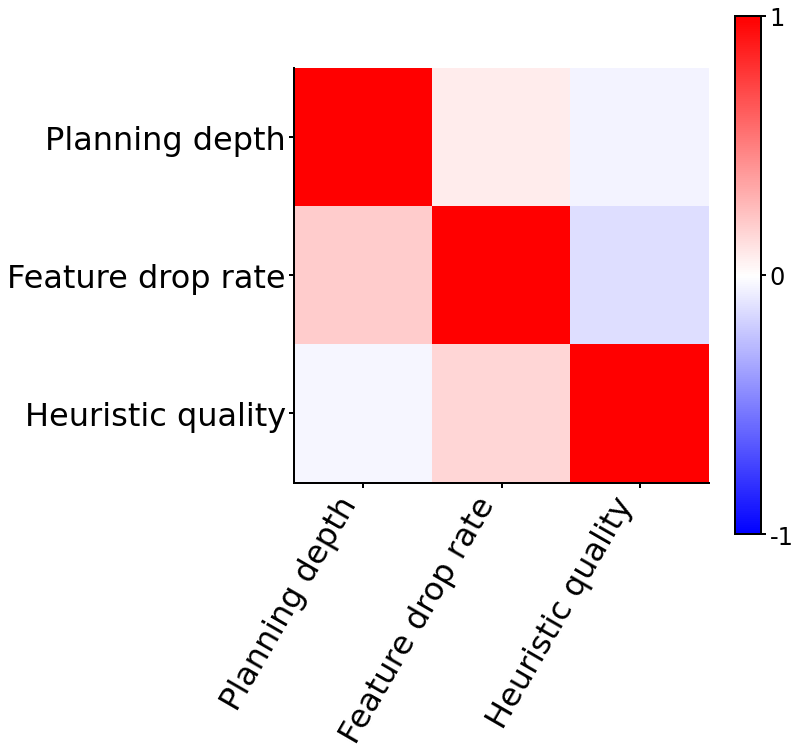

In [246]:
plot_with_stars(rho1,P1,'bwr',[-1,1],'supp_figure_7B.pdf')

In [247]:
D2 = np.array([[sts.ks_2samp(Mfull[i,:],Mlesions[j,i,:])[0] for i in range(3)] for j in range(3)])
P2 = np.array([[sts.ks_2samp(Mfull[i,:],Mlesions[j,i,:])[1] for i in range(3)] for j in range(3)])

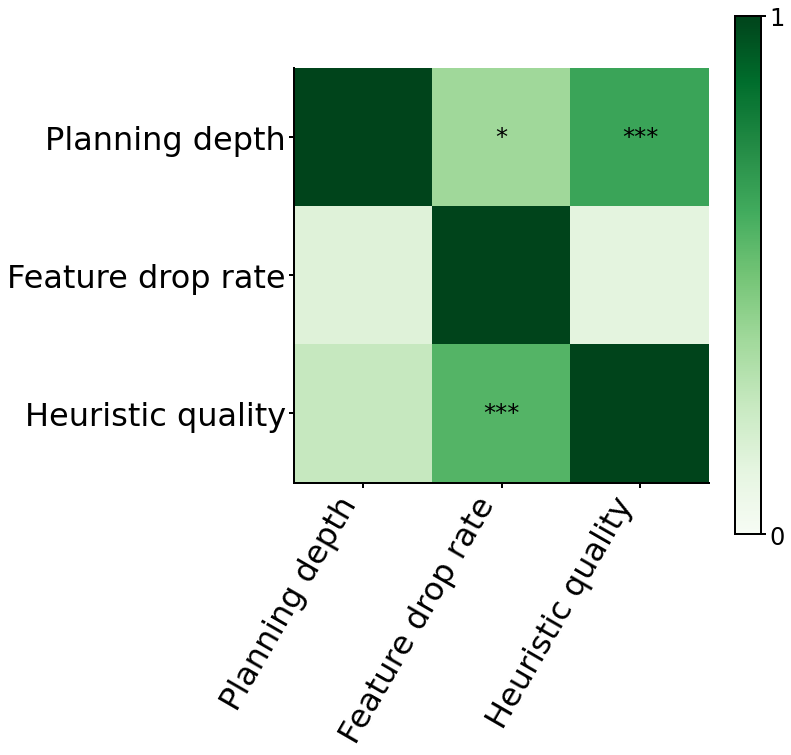

In [248]:
plot_with_stars(D2,P2,'Greens',[0,1],'supp_figure_7A.pdf')